In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
plt.style.use('fivethirtyeight')

## Read and preprocess data from json

In [2]:
sent_f = open("data/sentiment_data.json")
twitter_f = open("data/tweets.json")
google_dict = json.load(sent_f)
twitter_dict = json.load(twitter_f)

In [3]:
Xs = np.array(list(twitter_dict.values()))
Ys = []
for id in google_dict.keys():
    Ys.append(google_dict[id]["Score"])
Ys = np.array(Ys)
Ys = (Ys*10).astype(int)

#### Create train test split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.15)

#### Vectorize strings so they can go into models

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

#### Create baseline data set

In [6]:
rand_X = np.random.randint(low=-10, high=10, size=np.shape(X_test))

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators = 100, random_state = 0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rand_pred = regr.predict(rand_X)

print("Mean squared error: %.2f" % skl.metrics.mean_squared_error(y_test, y_pred))
print("Coefficient of determination (r2): %.2f" % skl.metrics.r2_score(y_test, y_pred))
print(f"Baseline r2: {skl.metrics.r2_score(y_test,rand_pred)}")

Mean squared error: 5.45
Coefficient of determination (r2): 0.59
Baseline r2: -0.2792080696107635


#### Lets try some grid search with n_estimators changing 

In [8]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            #'max_depth': range(3,7),
            'n_estimators': [int(x) for x in np.linspace(1,21,10)],
        },
        cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_n = grid_result.best_params_
regr = RandomForestRegressor(n_estimators=best_n["n_estimators"], random_state=False, verbose=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rand_pred = regr.predict(rand_X)

print("Mean squared error: %.2f" % skl.metrics.mean_squared_error(y_test, y_pred))
print("Coefficient of determination (r2): %.2f" % skl.metrics.r2_score(y_test, y_pred))
print(f"Baseline r2: {skl.metrics.r2_score(y_test,rand_pred)}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.1s
[CV] END .....................................n_estimators=1; total time=   0.1s
[CV] END .....................................n_estimators=3; total time=   0.1s
[CV] END .....................................n_estimators=3; total time=   0.1s
[CV] END .....................................n_estimators=3; total time=   0.1s
[CV] END .....................................n_estimators=5; total time=   0.2s
[CV] END .....................................n_estimators=5; total time=   0.2s
[CV] END .....................................n_estimators=5; total time=   0.2s
[CV] END .....................................n_estimators=7; total time=   0.3s
[CV] END .....................................n_estimators=7; total time=   0.3s
[CV] END .....................................n_

In [9]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    #train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    #plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

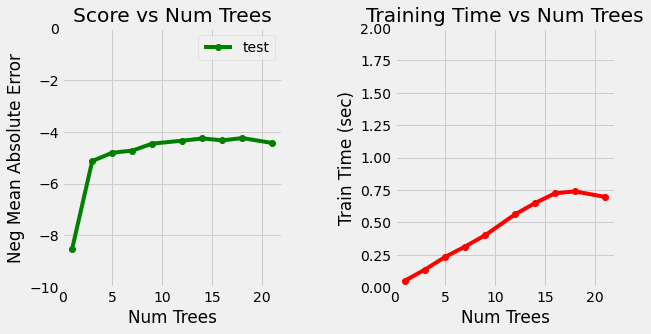

In [10]:
plot_results(grid_result)

In [11]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(2,20),
        },
        cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_depth = grid_result.best_params_
regr = RandomForestRegressor(max_depth=best_depth['max_depth'], random_state=False, verbose=False)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
rand_pred = regr.predict(rand_X)

print("Mean squared error: %.2f" % skl.metrics.mean_squared_error(y_test, y_pred))
print("Coefficient of determination (r2): %.2f" % skl.metrics.r2_score(y_test, y_pred))
print(f"Baseline r2: {skl.metrics.r2_score(y_test,rand_pred)}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=3; total time=   0.7s
[CV] END ........................................max_depth=3; total time=   0.7s
[CV] END ........................................max_depth=3; total time=   0.6s
[CV] END ........................................max_depth=4; total time=   0.8s
[CV] END ........................................max_depth=4; total time=   0.8s
[CV] END ........................................max_depth=4; total time=   0.8s
[CV] END ........................................max_depth=5; total time=   0.9s
[CV] END ........................................max_depth=5; total time=   0.9s
[CV] END .......................................

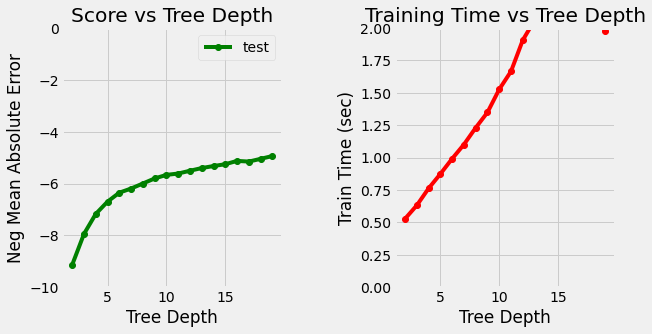

In [12]:
plot_results(grid_result, param='max_depth', name='Tree Depth')

### Save optimal model

In [13]:
regr = RandomForestRegressor(n_estimators=best_n["n_estimators"], max_depth=best_depth["max_depth"], random_state=False, verbose=False)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=19, n_estimators=18, random_state=False,
                      verbose=False)

In [36]:
import pickle
file = 'random_forest_protector.pkl'
pickle.dump(regr, open(file, 'wb'))
file = 'vectorizer.pkl'
pickle.dump(vectorizer, open(file, 'wb'))

In [35]:
string = "I suck at programming. Imma kill myself."
num_str = vectorizer.transform([string])
regr.predict(num_str)

array([0.74672038])